In [1]:
station_name = "Marshall"

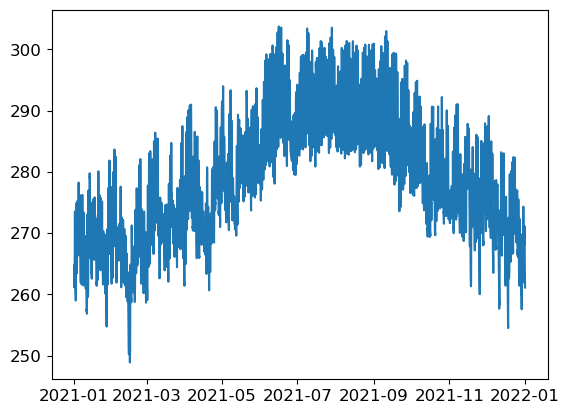

In [13]:
import xarray as xr

# era5_file in test folder
era5_file = f"/work/bm1159/XCES/xces-work/k203179/data/test/era5_for_{station_name.lower()}.nc"
cleaned_station_file = f"/work/bm1159/XCES/xces-work/k203179/data/test/expected_{station_name.lower()}.nc"

ds = xr.open_dataset(era5_file)

time = ds.time.values
tas = ds.tas.values.mean(axis=(1,2))

import matplotlib.pyplot as plt
plt.plot(time, tas)
plt.show()


In [14]:
from climatereconstructionai import evaluate

evaluate(f"test_args_{station_name.lower()}.txt")

/home/k/k203179/.conda/envs/crai/lib/python3.10/site-packages/climatereconstructionai/utils/normalizer.py:10: RuntimeWarning: Mean of empty slice
  img_mean.append(np.nanmean(np.array(img_data[i])))
/home/k/k203179/.conda/envs/crai/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
100%|██████████| 1/1 [00:03<00:00,  3.78s/it]


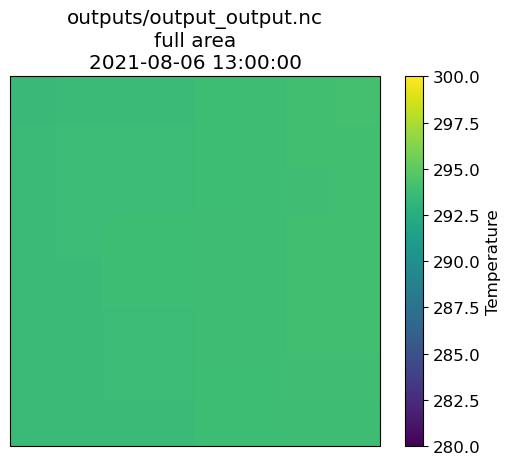

In [15]:
import xarray as xr

test_folder_path = "/work/bm1159/XCES/xces-work/k203179/data/test"
output_folder_path = "outputs"

from utils import DataSet, DatasetPlotter

ds = DataSet(output_folder_path + "/output_output.nc")
plotter = DatasetPlotter(ds)
plotter.time_index_list = [5000]
plotter.vmin = 280
plotter.vmax = 300
plotter.plot()

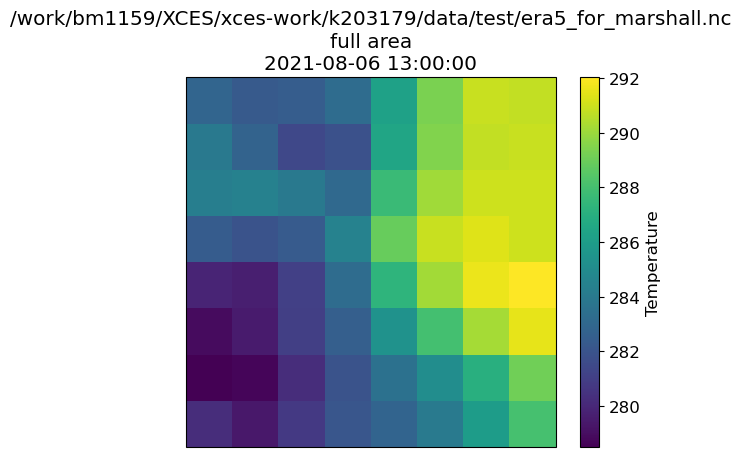

In [16]:
ds = DataSet(f"/work/bm1159/XCES/xces-work/k203179/data/test/era5_for_{station_name.lower()}.nc")
plotter = DatasetPlotter(ds)
plotter.time_index_list = [5000]
plotter.plot()

In [17]:
# get reality values
reality_data = xr.open_dataset(test_folder_path + f"/reality_{station_name.lower()}.nc")

In [19]:
def era_vs_output_comparision_to_df():
    era5_data = xr.open_dataset(test_folder_path + f"/era5_for_{station_name.lower()}.nc")
    output_data = xr.open_dataset(output_folder_path + "/output_output.nc")

    # get middle coordinates of era5
    lats = era5_data.variables["lat"][:]
    lons = era5_data.variables["lon"][:]
    lat_idx = int(len(lats) / 2)
    lon_idx = int(len(lons) / 2)

    if len(lats) % 2 == 0 and len(lons) % 2 == 0:
        era5_mid_values = era5_data.variables["tas"][:, lat_idx-1:lat_idx+1, lon_idx-1:lon_idx+1].mean(axis=(1,2))
    else:
        era5_mid_values = era5_data.variables["tas"][:, lat_idx:lat_idx+1, lon_idx:lon_idx+1].mean(axis=(1,2))
    era5_mean_values = era5_data.variables["tas"][:, :, :].mean(axis=(1,2))
    reality_data_values = reality_data.variables["tas"][:, 0, 0]
    output_data_values = output_data.variables["tas"][:, 0, 0]

    # timeaxis 
    time = reality_data.variables["time"][:]
    
    import pandas as pd

    # create dataframe with all values
    df = pd.DataFrame()

    df["time"] = time

    # index should be time
    df.set_index("time", inplace=True)

    df["era5_mean"] = era5_mean_values
    df["era5_mid"] = era5_mid_values
    df["output"] = output_data_values
    df["reality"] = reality_data_values

    return df


# Generate Dataframe
- makes resampling easier

In [20]:
hourly_df = era_vs_output_comparision_to_df()
hourly_df

,era5_mean,era5_mid,output,reality
time,,,,
2020-12-31 23:00:00,264.693115,264.343323,275.452576,273.989576
2021-01-01 00:00:00,264.155914,263.585419,274.688080,273.514184
2021-01-01 01:00:00,263.033203,262.406494,273.066925,273.826363
2021-01-01 02:00:00,262.770508,261.133545,272.903870,274.470134
2021-01-01 03:00:00,261.185608,259.514404,271.829041,274.238771
...,...,...,...,...
2021-12-31 19:00:00,264.361633,263.919006,271.769745,271.432790
2021-12-31 20:00:00,262.589539,262.033112,269.761719,272.612024
2021-12-31 21:00:00,262.568207,262.064972,269.518829,270.582825


# Implement plotting method of dataframe

In [23]:
def plot_n_steps_of_df(df, as_delta, n=None, title=None):
    
    time = df.index.values
    
    reality_values = df["reality"].values
    
    if as_delta:
        era5_mid_values = df["era5_mid"].values - reality_values
        era5_mean_values = df["era5_mean"].values - reality_values
        output_values = df["output"].values - reality_values
    else:
        era5_mid_values = df["era5_mid"].values
        era5_mean_values = df["era5_mean"].values
        output_values = df["output"].values
    
    if n is None:
        n = len(df)
    
    # random slice of n consecutive datapoints
    import random
    slice_start = random.randint(0, len(time) - n)
    time_slice = slice(slice_start, slice_start + n)

    time = time[time_slice]

    # plot for each dataset the tas values at the middle coordinates
    from matplotlib import pyplot as plt
    

    plt.plot(time, era5_mean_values[time_slice], label="era5 mean")
    plt.plot(time, era5_mid_values[time_slice], label="era5 mid")
    plt.plot(time, output_values[time_slice], label="output")
    
    if not as_delta:
        plt.plot(time, reality_values[time_slice], label="reality")

    # x-axis labels 90 degrees
    plt.xticks(rotation=90)
    
    # title
    if title is not None:
        plt.title(title)
    
    # font size of legend
    plt.rcParams.update({'font.size': 12})
    
    # font size of axis labels
    plt.rcParams.update({'axes.labelsize': 12})

    plt.legend()
    plt.show()

Plot Hourly (deltas), so errors against real measurements

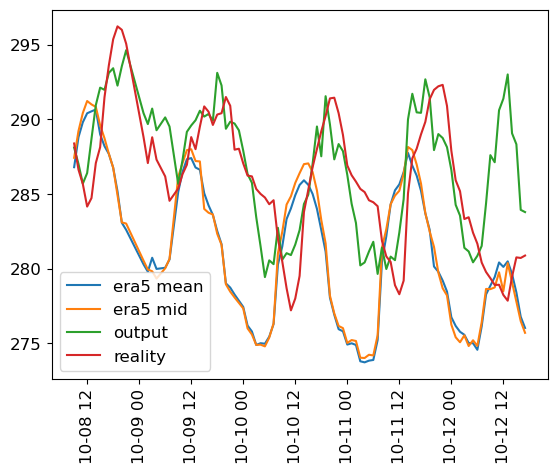

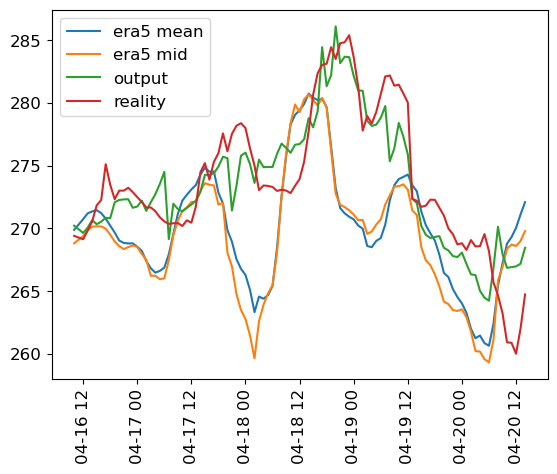

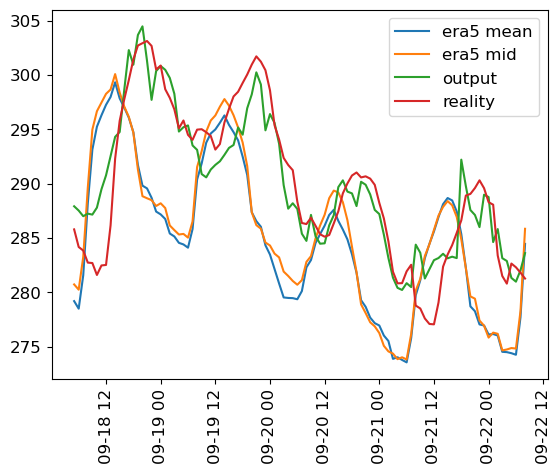

In [22]:
title = f"{station_name} - 100 random conseq steps - delta"
plot_n_steps_of_df(hourly_df, as_delta=False, n=100)
plot_n_steps_of_df(hourly_df, as_delta=False, n=100)
plot_n_steps_of_df(hourly_df, as_delta=False, n=100)

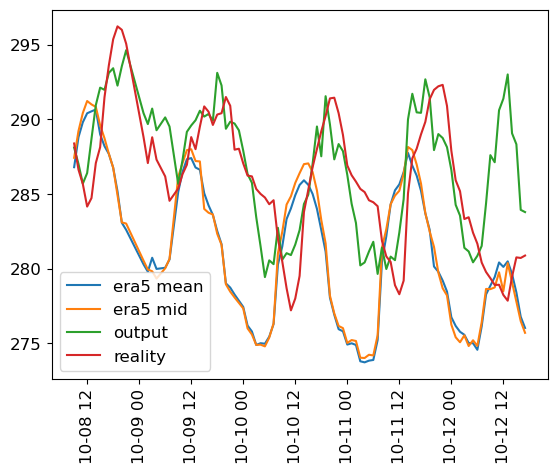

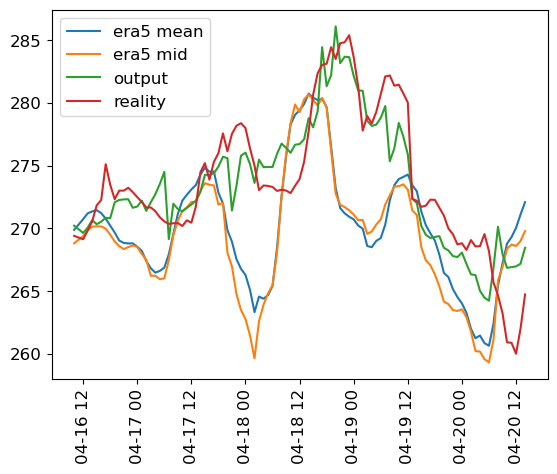

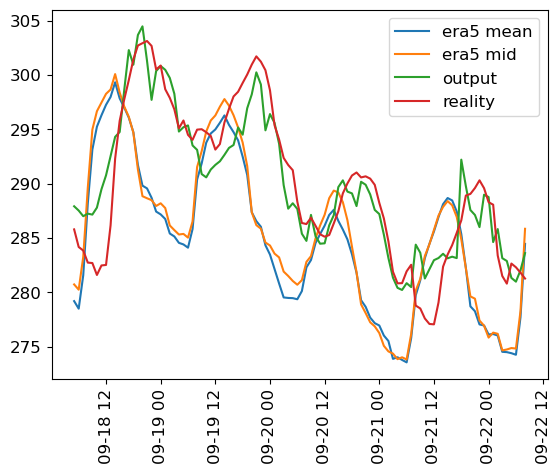

In [ ]:
title = f"{station_name} - 100 random conseq steps - delta"
plot_n_steps_of_df(hourly_df, as_delta=False, n=100)
plot_n_steps_of_df(hourly_df, as_delta=False, n=100)
plot_n_steps_of_df(hourly_df, as_delta=False, n=100)

## Resample Data from hourly to dails or monthly




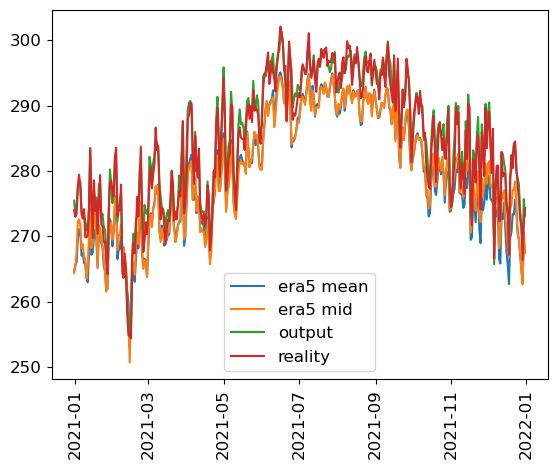

In [11]:
daily_df = hourly_df.resample("D").mean()
plot_n_steps_of_df(daily_df, as_delta = False)

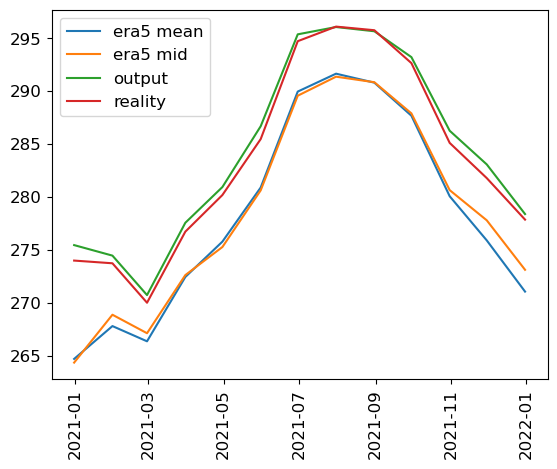

In [12]:
# resample rows to monthly mean

df = hourly_df.resample("M").mean()
plot_n_steps_of_df(df, as_delta = False)